In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os
from scipy.stats import norm
from datetime import datetime, timedelta
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima 
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from sklearn.metrics import mean_squared_error 
from statsmodels.tools.eval_measures import rmse
import warnings 
from tqdm import tqdm

In [34]:
# Load the dataset
ynthetic_data = pd.read_csv("synthetic_woolworths_cleaned.csv")
# Convert 'Purchase Date' to datetime
synthetic_data["Purchase Date"] = pd.to_datetime(synthetic_data["Purchase Date"])

,Transaction ID,Purchase Date,Store Name,Location,Customer ID,Gender,Item ID,Brand,Item Name,Category,Product Code,Unit Price,Discount Price,Discount Amount,Quantity,Total,Payment Type
0,WOOL-942444F417,2024-08-31,Metro,Canberra,WOOL-CC53826C8A,Female,83E34EE467,Cavendish,Cavendish Bananas Each,Fruit & Veg,133211,0.81,0.81,0.0,5,4.05,Store card
1,WOOL-333D0B3F6A,2024-11-13,Metro,Melbourne,WOOL-7F662F3FA2,Other,8D76DA04FE,Fresh,Fresh Tomato Each,Fruit & Veg,134034,0.65,0.65,0.0,1,0.65,Gift card
2,WOOL-8741987CC1,2024-09-13,Woolworths,Sydney,WOOL-765C1DAD58,Female,2620957AB6,Fresh,Fresh Pink Lady Apples Each,Fruit & Veg,105919,0.86,0.86,0.0,10,8.60,Store card
3,WOOL-A243360831,2024-10-28,Woolworths,Melbourne,WOOL-F4751A08ED,Male,B86D29C6A4,Strawberries,Strawberries 250g Punnet,Fruit & Veg,144607,2.30,2.30,0.0,7,16.10,Cash
4,WOOL-2A6D03A1FB,2024-10-09,Woolworths,Sydney,WOOL-14E973EE0E,Female,06D51874A2,Hass,Hass Avocado Each,Fruit & Veg,120080,2.20,2.20,0.0,10,22.00,Store card


In [35]:
# Path to folder with CSV files
folder_path = "Macro_data"

# Loop through all price CSV files and merge them one by one
for file in os.listdir(folder_path):
    if file.endswith(".csv"):
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path)

        # Step 1: Parse the date using the correct original format
        df["Date"] = pd.to_datetime(df["Date"], dayfirst=True)

        # Rename value column (e.g., "Close") to something unique
        value_col = [col for col in df.columns if col != "Date"][0]
        new_col_name = file.replace(".csv", "")
        df = df.rename(columns={value_col: new_col_name})

        # Merge on date fields
        synthetic_data = pd.merge(
            synthetic_data,
            df[["Date", new_col_name]],
            how="left",
            left_on="Purchase Date",
            right_on="Date"
        )

        # Drop the extra 'Date' column after merge
        synthetic_data.drop(columns=["Date"], inplace=True)

    Transaction ID Purchase Date  Store Name   Location      Customer ID  \
0  WOOL-942444F417    2024-08-31       Metro   Canberra  WOOL-CC53826C8A   
1  WOOL-333D0B3F6A    2024-11-13       Metro  Melbourne  WOOL-7F662F3FA2   
2  WOOL-8741987CC1    2024-09-13  Woolworths     Sydney  WOOL-765C1DAD58   
3  WOOL-8741987CC1    2024-09-13  Woolworths     Sydney  WOOL-765C1DAD58   
4  WOOL-A243360831    2024-10-28  Woolworths  Melbourne  WOOL-F4751A08ED   

   Gender     Item ID         Brand                    Item Name     Category  \
0  Female  83E34EE467     Cavendish       Cavendish Bananas Each  Fruit & Veg   
1   Other  8D76DA04FE         Fresh            Fresh Tomato Each  Fruit & Veg   
2  Female  2620957AB6         Fresh  Fresh Pink Lady Apples Each  Fruit & Veg   
3  Female  2620957AB6         Fresh  Fresh Pink Lady Apples Each  Fruit & Veg   
4    Male  B86D29C6A4  Strawberries     Strawberries 250g Punnet  Fruit & Veg   

   ...  World Milk Price  World Natural Gas Price  World

In [36]:
# Create binary flags based on whether the item name contains the keyword
synthetic_data["Corn_contained"] = synthetic_data["Item Name"].str.contains("Corn", case=False, na=False).astype(int)
synthetic_data["Cocoa_contained"] = synthetic_data["Item Name"].str.contains("Cocoa", case=False, na=False).astype(int)
synthetic_data["Coffee_contained"] = synthetic_data["Item Name"].str.contains("Coffee", case=False, na=False).astype(int)
synthetic_data["Cotton_contained"] = synthetic_data["Item Name"].str.contains("Cotton", case=False, na=False).astype(int)
synthetic_data["Cotton_contained"] = synthetic_data["Item Name"].str.contains("Cotton", case=False, na=False).astype(int)
synthetic_data["Beef_contained"] = synthetic_data["Item Name"].str.contains("Beef", case=False, na=False).astype(int)
synthetic_data["Milk_contained"] = synthetic_data["Item Name"].str.contains("Milk", case=False, na=False).astype(int)
synthetic_data["Orange_Juice_contained"] = synthetic_data["Item Name"].str.contains("Orange Juice", case=False, na=False).astype(int)
synthetic_data["Pork_contained"] = synthetic_data["Item Name"].str.contains("Pork", case=False, na=False).astype(int)
synthetic_data["Rice_contained"] = synthetic_data["Item Name"].str.contains("Rice", case=False, na=False).astype(int)
synthetic_data["Soybean_contained"] = synthetic_data["Item Name"].str.contains("Soybean", case=False, na=False).astype(int)
synthetic_data["Sugar_contained"] = synthetic_data["Item Name"].str.contains("Sugar", case=False, na=False).astype(int)
synthetic_data["Wheat_contained"] = synthetic_data["Item Name"].str.contains("Wheat", case=False, na=False).astype(int)

# Define regex pattern to match 'Oats' or 'Oat Milk' only
pattern = r"\b(?:Oats|Oat Milk)\b"
# Create Oats_contained column
synthetic_data["Oats_contained"] = synthetic_data["Item Name"].str.contains(pattern, flags=re.IGNORECASE, regex=True).astype(int)

    Transaction ID Purchase Date  Store Name   Location      Customer ID  \
0  WOOL-942444F417    2024-08-31       Metro   Canberra  WOOL-CC53826C8A   
1  WOOL-333D0B3F6A    2024-11-13       Metro  Melbourne  WOOL-7F662F3FA2   
2  WOOL-8741987CC1    2024-09-13  Woolworths     Sydney  WOOL-765C1DAD58   
3  WOOL-8741987CC1    2024-09-13  Woolworths     Sydney  WOOL-765C1DAD58   
4  WOOL-A243360831    2024-10-28  Woolworths  Melbourne  WOOL-F4751A08ED   

   Gender     Item ID         Brand                    Item Name     Category  \
0  Female  83E34EE467     Cavendish       Cavendish Bananas Each  Fruit & Veg   
1   Other  8D76DA04FE         Fresh            Fresh Tomato Each  Fruit & Veg   
2  Female  2620957AB6         Fresh  Fresh Pink Lady Apples Each  Fruit & Veg   
3  Female  2620957AB6         Fresh  Fresh Pink Lady Apples Each  Fruit & Veg   
4    Male  B86D29C6A4  Strawberries     Strawberries 250g Punnet  Fruit & Veg   

   ...  Cotton_contained  Beef_contained  Milk_contained

In [37]:
# Identify all columns that start with 'World' and end with 'Price'
world_price_cols = [col for col in synthetic_data.columns if col.startswith("World") and col.endswith("Price")]

# Apply forward-fill (fill NaN with previous value) for those columns
synthetic_data[world_price_cols] = synthetic_data[world_price_cols].fillna(method='ffill')
synthetic_data = synthetic_data[synthetic_data["Discount Amount"] >= 0]

,Transaction ID,Purchase Date,Store Name,Location,Customer ID,Gender,Item ID,Brand,Item Name,Category,...,Cotton_contained,Beef_contained,Milk_contained,Orange_Juice_contained,Pork_contained,Rice_contained,Soybean_contained,Sugar_contained,Wheat_contained,Oats_contained
0,WOOL-942444F417,2024-08-31,Metro,Canberra,WOOL-CC53826C8A,Female,83E34EE467,Cavendish,Cavendish Bananas Each,Fruit & Veg,...,0,0,0,0,0,0,0,0,0,0
1,WOOL-333D0B3F6A,2024-11-13,Metro,Melbourne,WOOL-7F662F3FA2,Other,8D76DA04FE,Fresh,Fresh Tomato Each,Fruit & Veg,...,0,0,0,0,0,0,0,0,0,0
2,WOOL-8741987CC1,2024-09-13,Woolworths,Sydney,WOOL-765C1DAD58,Female,2620957AB6,Fresh,Fresh Pink Lady Apples Each,Fruit & Veg,...,0,0,0,0,0,0,0,0,0,0
3,WOOL-8741987CC1,2024-09-13,Woolworths,Sydney,WOOL-765C1DAD58,Female,2620957AB6,Fresh,Fresh Pink Lady Apples Each,Fruit & Veg,...,0,0,0,0,0,0,0,0,0,0
4,WOOL-A243360831,2024-10-28,Woolworths,Melbourne,WOOL-F4751A08ED,Male,B86D29C6A4,Strawberries,Strawberries 250g Punnet,Fruit & Veg,...,0,0,0,0,0,0,0,0,0,0


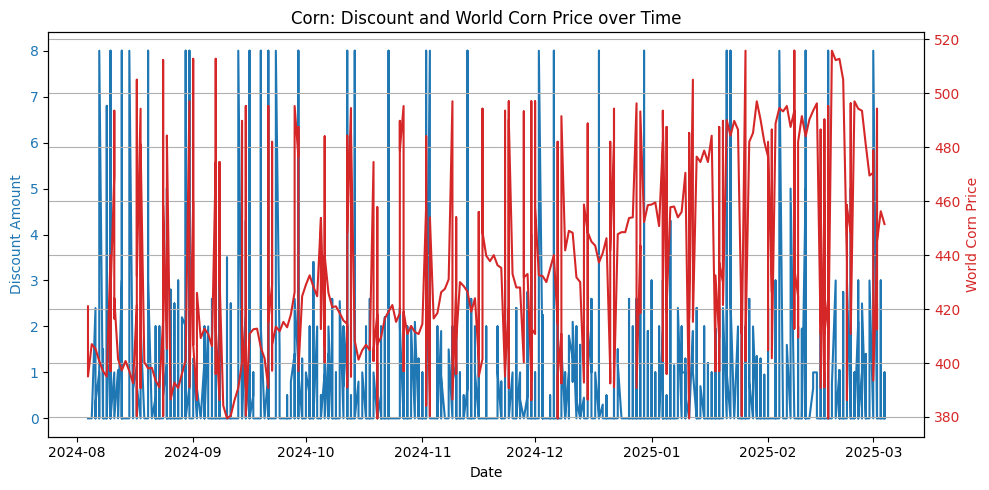

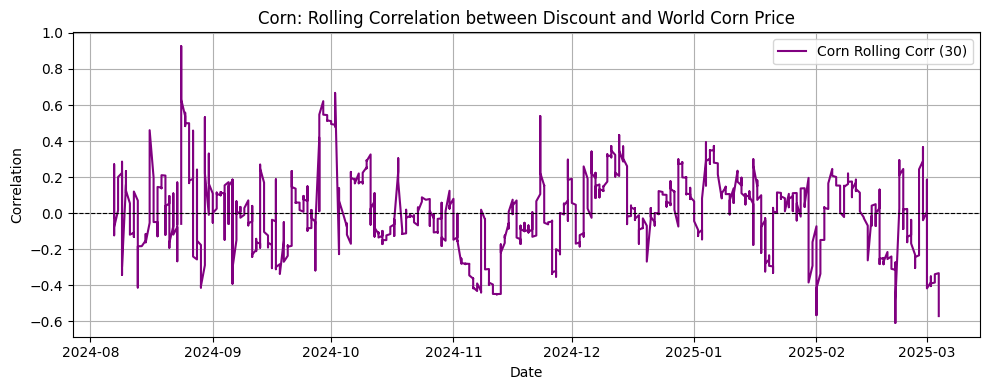

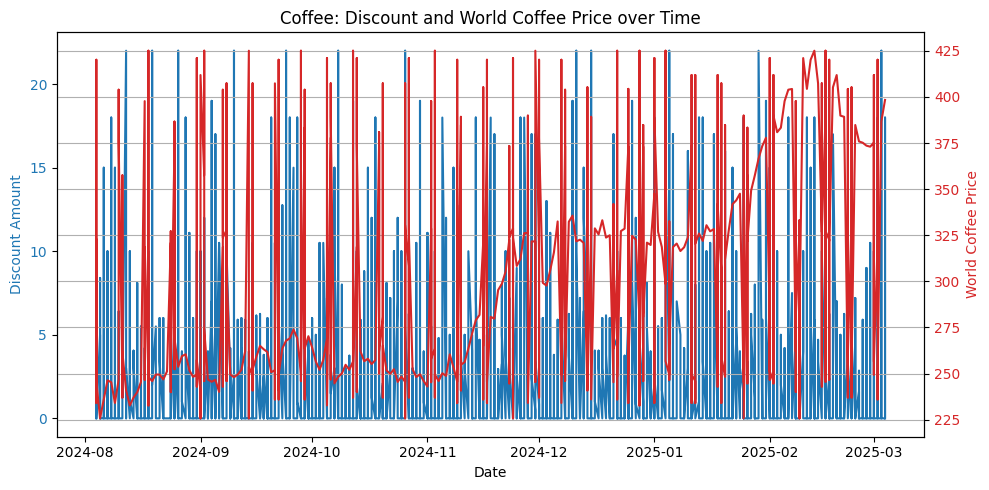

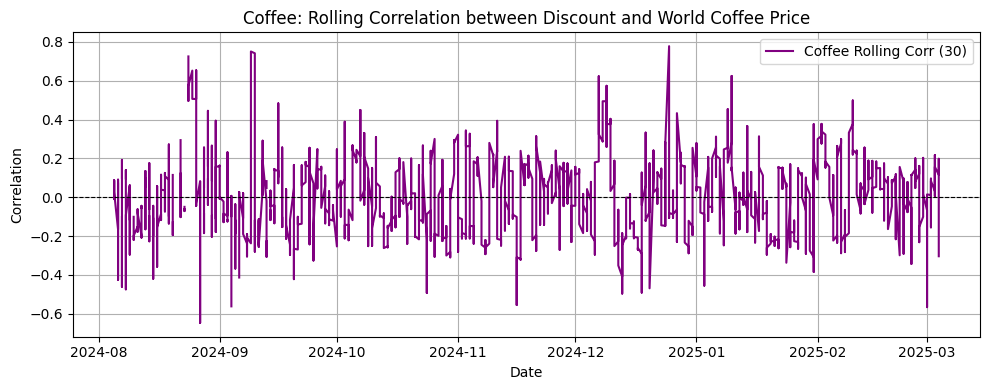

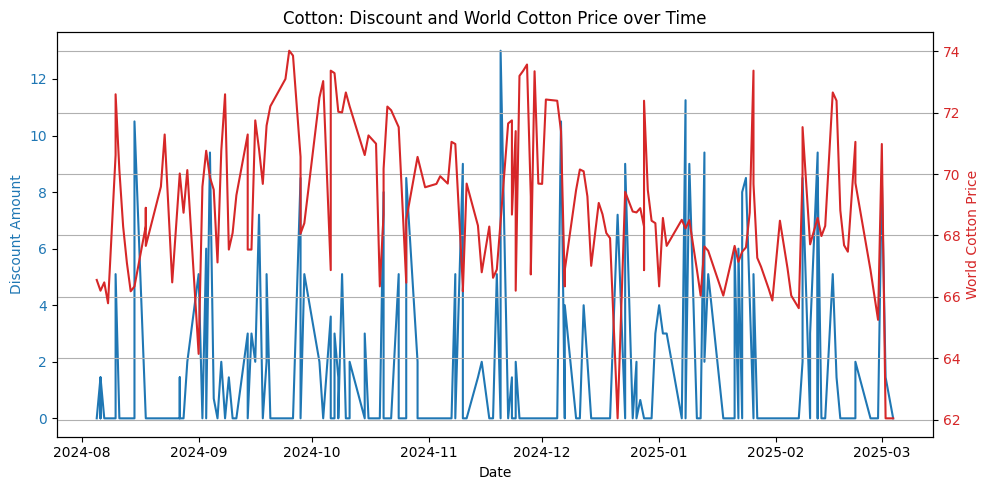

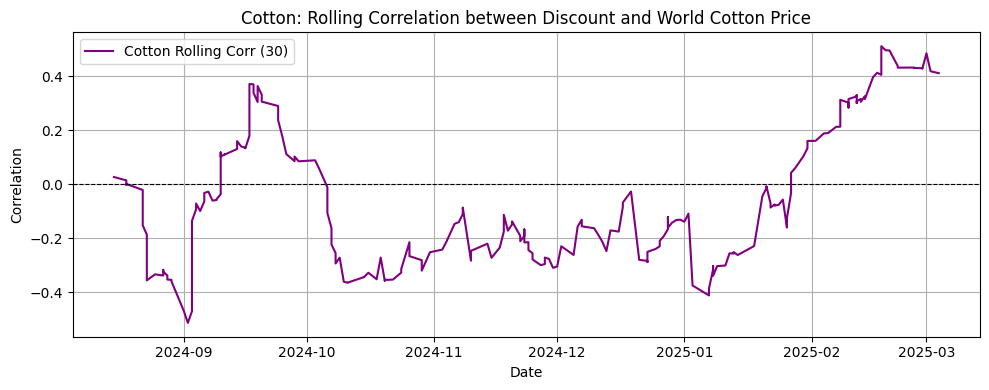

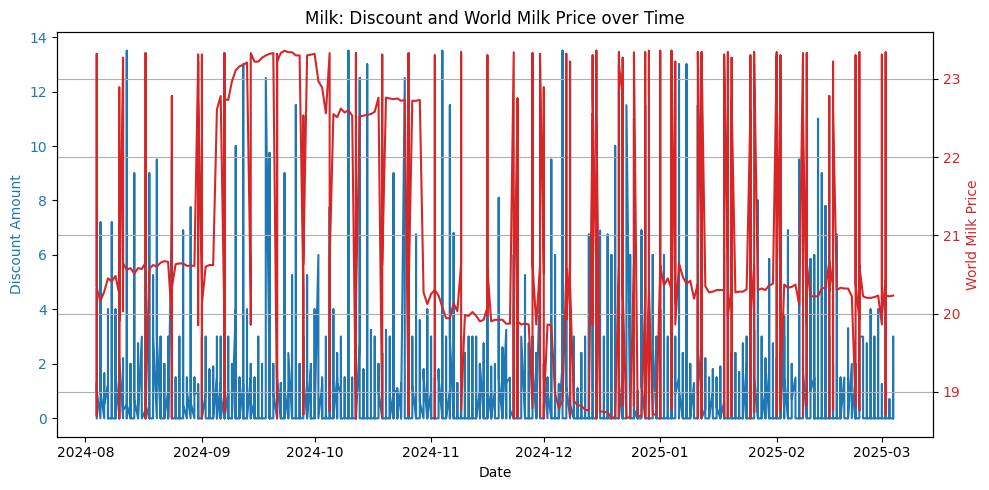

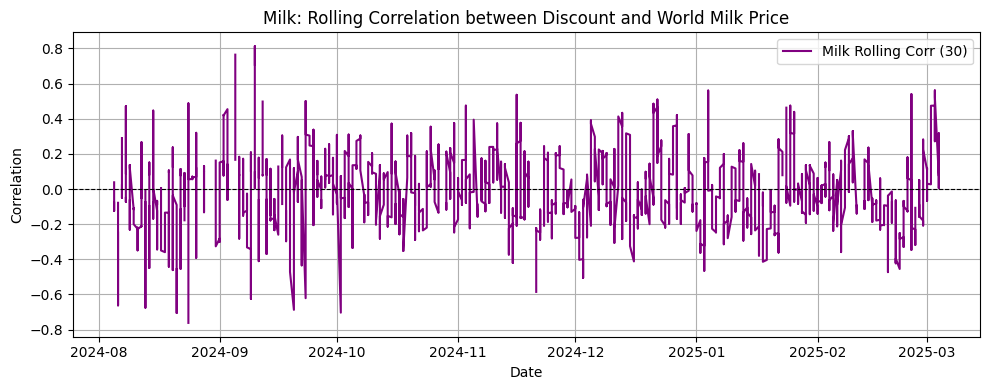

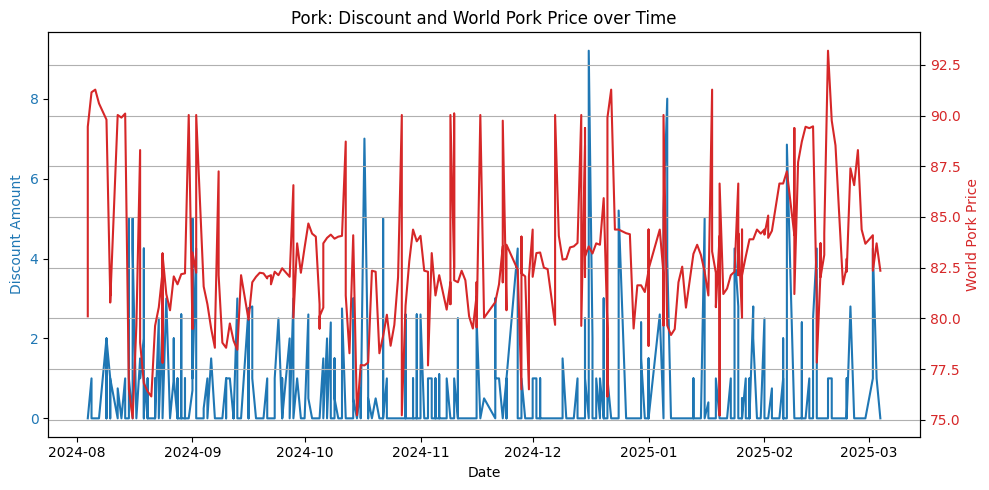

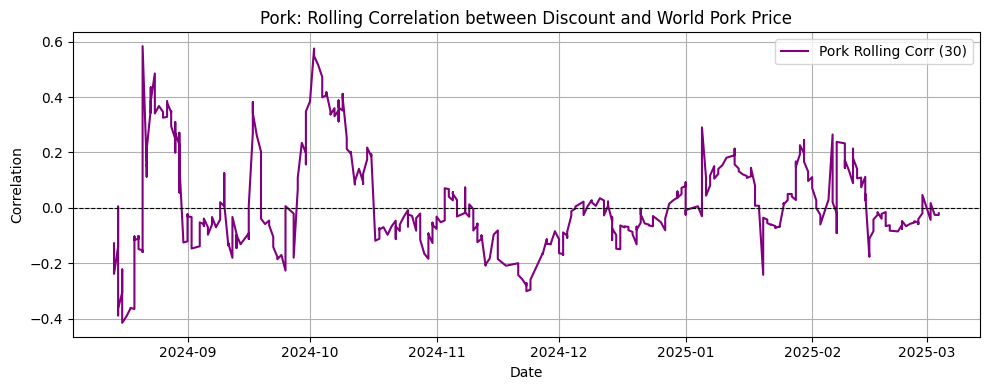

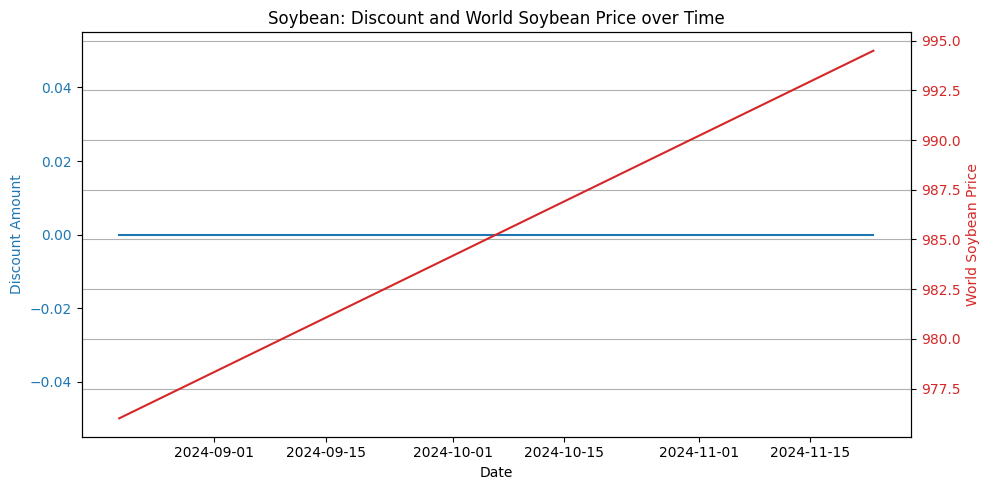

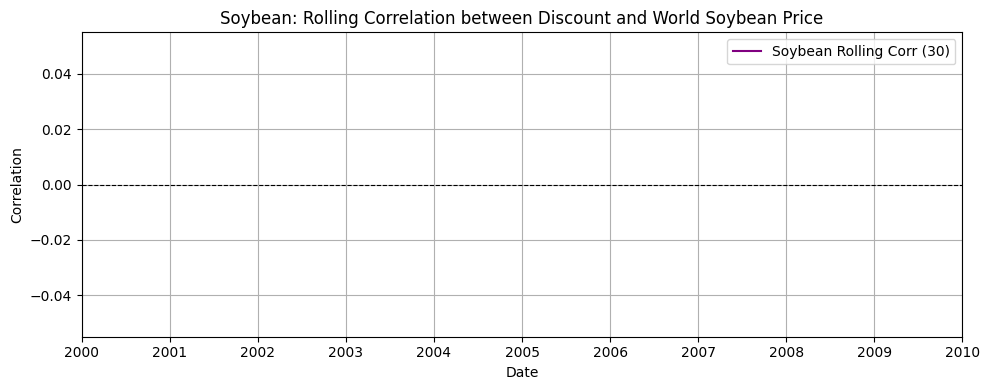

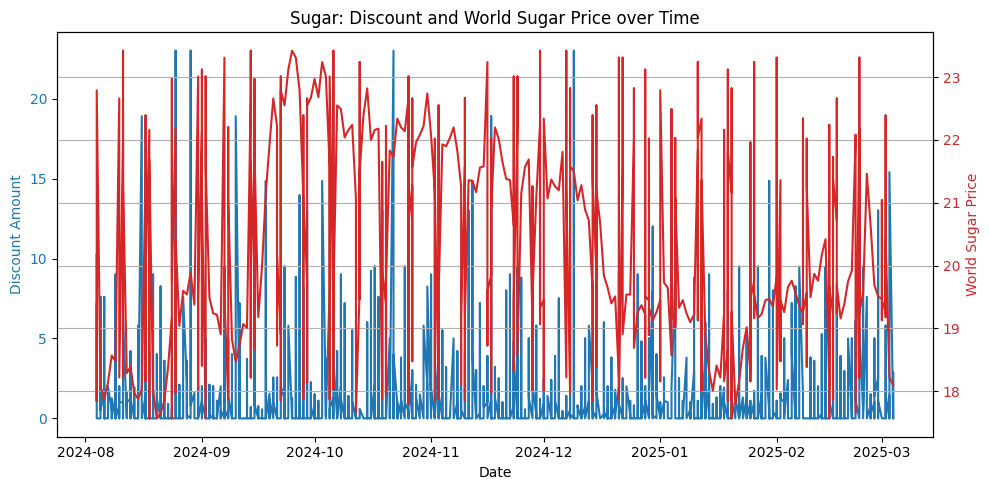

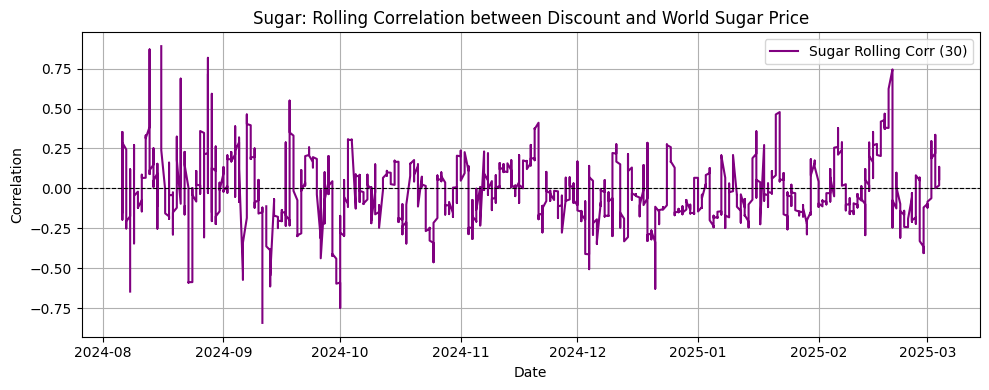

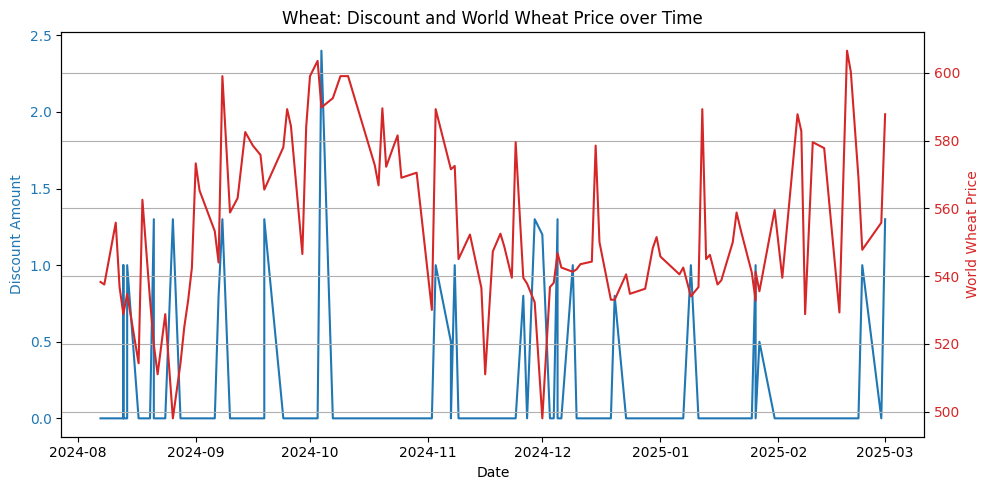

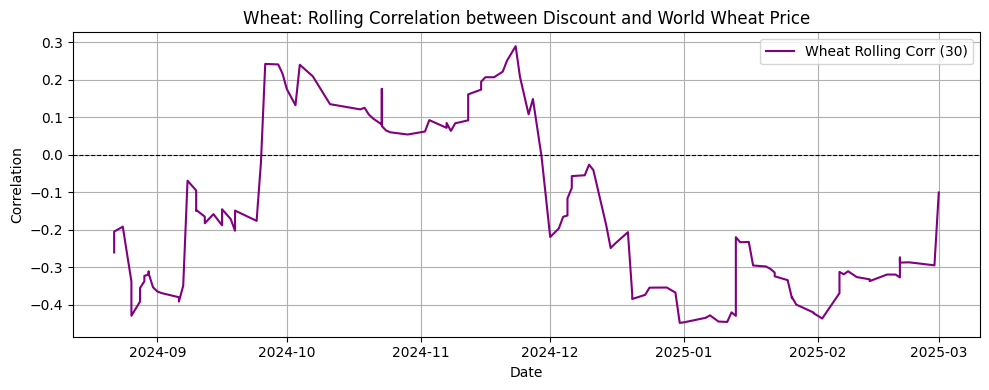

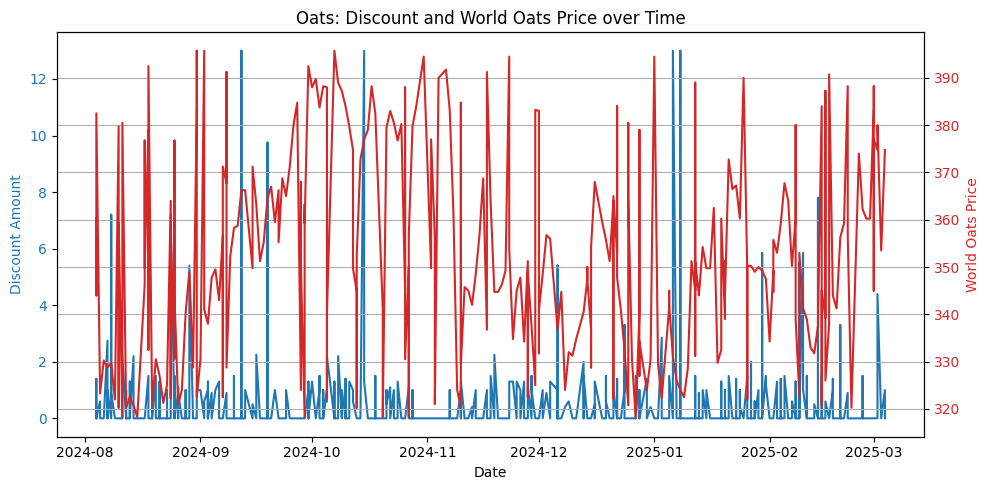

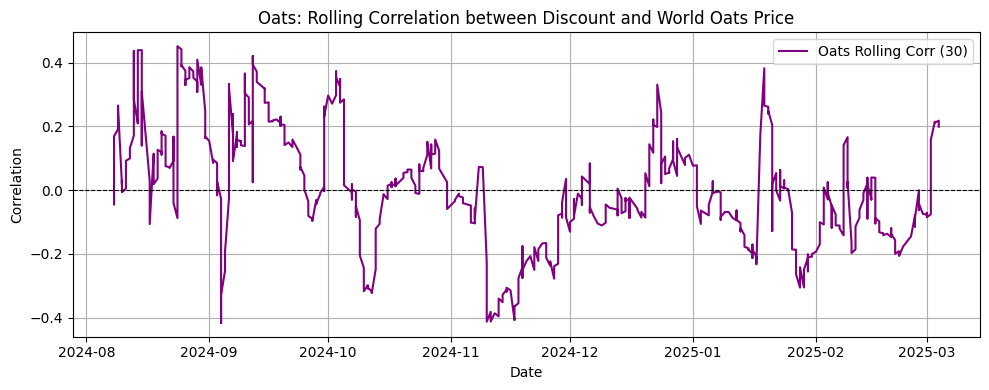

In [39]:
# Loop through _contained columns
for col in synthetic_data.columns:
    if col.endswith("_contained"):
        # Extract commodity name from the column name
        commodity = col.replace("_contained", "")
        price_col = f"World {commodity} Price"

        # Check if the corresponding price column exists
        if price_col in synthetic_data.columns:
            # Filter rows where contained flag is 1
            filtered = synthetic_data[synthetic_data[col] == 1].copy()

            # Ensure columns are numeric
            filtered["Discount Amount"] = pd.to_numeric(filtered["Discount Amount"], errors="coerce")
            filtered[price_col] = pd.to_numeric(filtered[price_col], errors="coerce")

            # Drop rows with missing values
            filtered.dropna(subset=["Discount Amount", price_col, "Purchase Date"], inplace=True)

            # Sort by date
            filtered["Purchase Date"] = pd.to_datetime(filtered["Purchase Date"], errors="coerce")
            filtered.sort_values("Purchase Date", inplace=True)

            if not filtered.empty:
                # Plot Discount and Price over Time (Dual-axis)
                fig, ax1 = plt.subplots(figsize=(10, 5))
                ax1.set_title(f"{commodity}: Discount and {price_col} over Time")
                ax1.set_xlabel("Date")
                ax1.set_ylabel("Discount Amount", color="tab:blue")
                ax1.plot(filtered["Purchase Date"], filtered["Discount Amount"], color="tab:blue", label="Discount Amount")
                ax1.tick_params(axis="y", labelcolor="tab:blue")

                ax2 = ax1.twinx()
                ax2.set_ylabel(price_col, color="tab:red")
                ax2.plot(filtered["Purchase Date"], filtered[price_col], color="tab:red", label=price_col)
                ax2.tick_params(axis="y", labelcolor="tab:red")

                fig.tight_layout()
                plt.grid(True)
                plt.show()

                # Plot Rolling Correlation Plot between Discount Amount and Price of the commodity
                # Number of days to calculate rolling correlation
                window_size = 30 

                # Set index to date for rolling operation
                temp = filtered.set_index("Purchase Date")[["Discount Amount", price_col]]

                # Calculate rolling correlation
                rolling_corr = temp["Discount Amount"].rolling(window=window_size).corr(temp[price_col])

                # Plot rolling correlation
                plt.figure(figsize=(10, 4))
                plt.plot(rolling_corr, color="purple", label=f"{commodity} Rolling Corr ({window_size})")
                plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
                plt.title(f"{commodity}: Rolling Correlation between Discount and {price_col}")
                plt.xlabel("Date")
                plt.ylabel("Correlation")
                plt.grid(True)
                plt.tight_layout()
                plt.legend()
                plt.show()

In [ ]:
warnings.filterwarnings("ignore") 

# Initialize a dictionary to store forecasts
forecasts = {}

# Get all unique item names
item_names = synthetic_data["Item Name"].unique()

# Loop through each item with progress bar
for item in tqdm(item_names):
    try:
        # Filter data for current item
        item_data = synthetic_data[synthetic_data["Item Name"] == item][['Purchase Date', 'Discount Amount']].copy()
        
        # Create full daily time series
        data_daily = item_data.groupby('Purchase Date').sum()
        all_days = pd.date_range(start=data_daily.index.min(), end=data_daily.index.max(), freq='D')
        data_item_subset_full = data_daily.reindex(all_days, fill_value=0)
        data_item_subset_full.index.name = 'Purchase Date'
    
        

        # Skip if data is too short for seasonal modeling
        if len(data_item_subset_full) < 14:
            continue

        if len(data_item_subset_full) < 30:
            # Fit multiple ARIMA models without seasonal
            stepwise_fit = auto_arima(
                data_item_subset_full,             
                start_p=1, start_q=1,
                max_p=3, max_q=3,
                m=7,
                start_P=0,
                seasonal=False,
                d=None,
                D=1,
                trace=False,
                error_action='ignore',
                suppress_warnings=True,
                stepwise=True
            )
        else:
            # Fit multiple ARIMA models
            stepwise_fit = auto_arima(
                data_item_subset_full,             
                start_p=1, start_q=1,
                max_p=3, max_q=3,
                m=7,
                start_P=0,
                seasonal=True,
                d=None,
                D=1,
                trace=False,
                error_action='ignore',
                suppress_warnings=True,
                stepwise=True
            )
    
        # Pick out the best ARIMA model to use for predicting
        order = stepwise_fit.order
        seasonal_order = stepwise_fit.seasonal_order
            
        model = SARIMAX(data_item_subset_full,  
                        order=order,  
                        seasonal_order=seasonal_order) 
              
        result = model.fit(disp=False)
              
        # Forecast for the next month 
        forecast_horizon = 30
        forecast = result.predict(start = len(data_item_subset_full),  
                                    end = len(data_item_subset_full) + forecast_horizon - 1,  
                                    typ = 'levels')
        forecast.name = item
        forecasts[item] = forecast

    except Exception as e:
            continue

# Combine forecasts into a DataFrame
forecast_df = pd.DataFrame(forecasts)
forecast_df.index.name = "Forecast Date"

forecast_df.head()

  7%|▋         | 1597/22926 [32:15<9:50:28,  1.66s/it] 